In [63]:
import matplotlib.pyplot as plt
import bids
import numpy as np
from ghost.bids import warp_thermo, get_temperature, _make_deriv_fname
from ghost.phantom import Caliber137
import ants

In [5]:
projdir = '/home/em2876lj/Projects/QA/QA_paper/project'
layout = bids.BIDSLayout(root=projdir+'/rawdata', derivatives=projdir+'/derivatives')

In [19]:
sub = 'P0003'
sessions = list({x.entities['session'] for x in layout.get(scope='derivatives', subject=sub)})

In [31]:
ses = sessions[0]


In [52]:
len(sessions)/4

5.5

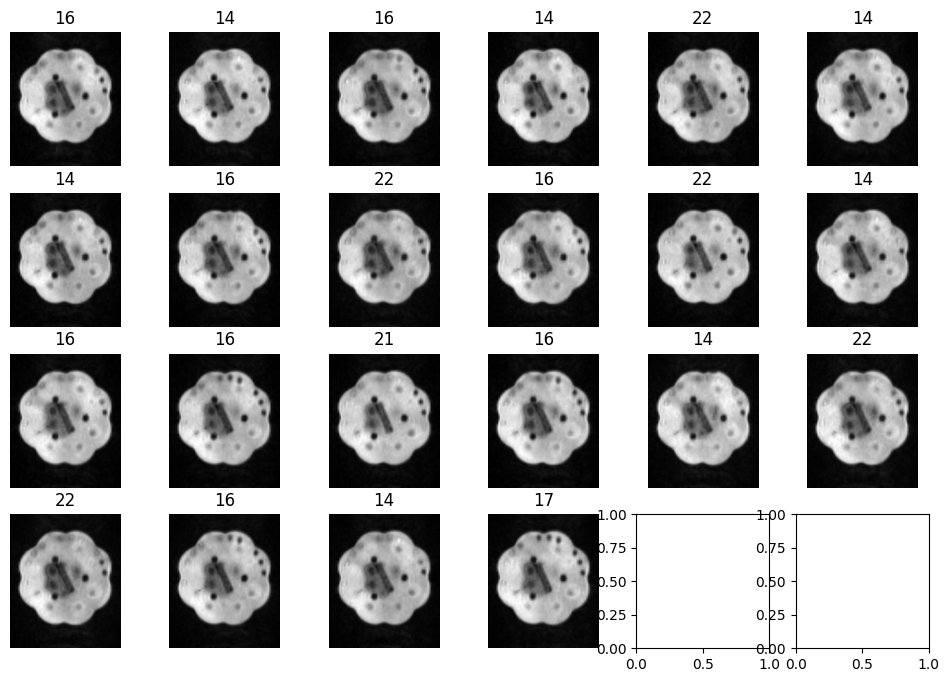

In [54]:
fig, axes = plt.subplots(4,6,figsize=(12,8))

for i in range(len(sessions)):
    ax = axes[np.unravel_index(i, [4,6])]
    temp_f = layout.get(scope='derivatives', subject=sub, session=sessions[i], extension='.txt', desc='temperature')[0].path
    fisp_img = layout.get(scope='derivatives', subject=sub, session=sessions[i], extension='.nii.gz', desc='regT2wN4')[0].get_image()

    ax.imshow(np.rot90(fisp_img.get_fdata()[:,:,23]), cmap='gray')
    ax.axis('off')
    
    with open(temp_f, 'r') as f:
        temperature = f.readline()

    ax.set_title(temperature)

np.int64(16)

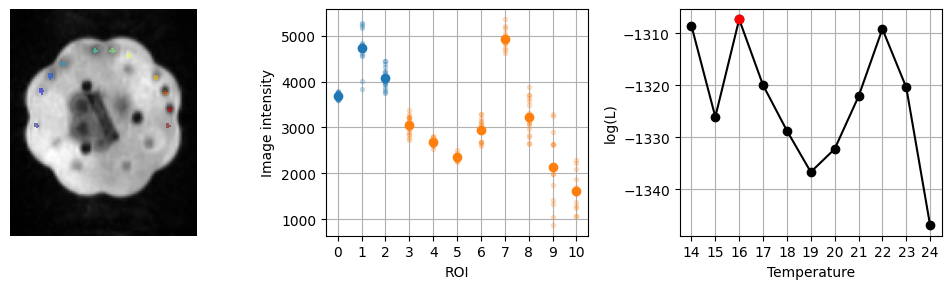

In [59]:
phantom = Caliber137()

axi1 = layout.get(scope='raw', extension='.nii.gz', subject=sub, reconstruction='axi', session=ses, run=1)[0]    
fisp = layout.get(scope='raw', extension='.nii.gz', subject=sub, suffix='PDw', session=ses)[0]
    
warp_thermo(layout, fisp, axi1, ow=False)

get_temperature(layout, 
                thermo=layout.get(scope='derivatives', suffix='PDw', subject=sub, session=ses, desc='regT2wN4')[0],
                phantom=phantom, plot_on=True)

In [84]:
moving = ants.image_read(fisp.path)
fixed = ants.image_read(axi1.path)
# reg = ants.registration(fixed, moving, type_of_transform='antsRegistrationSyN[s]')

phantom_mask = ants.image_read(_make_deriv_fname(layout, axi1.get_entities(), desc=f'segphantomMask', tool='ghost'))
N4 = ants.n4_bias_field_correction(reg['warpedmovout'], mask=phantom_mask, return_bias_field=True, shrink_factor=20)

corr_img = reg['warpedmovout']/N4

(np.int64(15), <Figure size 1000x300 with 3 Axes>)

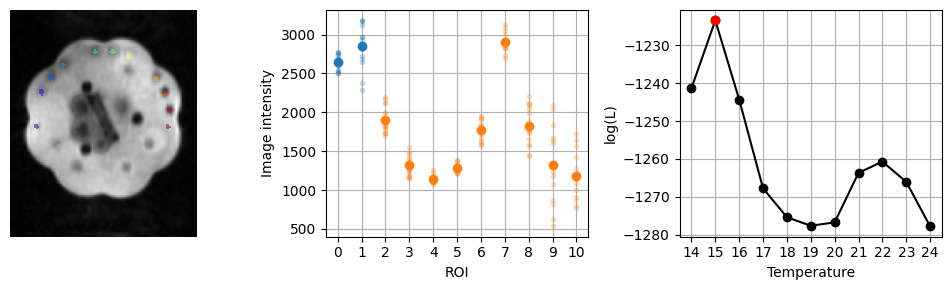

In [86]:
LC = layout.get(scope='derivatives', subject=sub, session=ses, desc='segLC')[0].path
phantom.loglike_temp(corr_img, LC, plot_on=True)

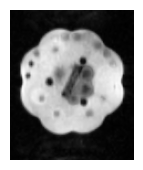

In [101]:
reg['warpedmovout'].plot(axis=2, slices=[23])